In [1]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
# function for extracting the features out of data in path
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [3]:
# saving the features for future use and make  program run fast
Features = pd.read_csv("feature.csv") 
Features.head()
Features

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.300781,0.706492,0.756853,0.735217,0.731014,0.715156,0.667529,0.673754,0.722173,0.748969,...,4.319263e-06,0.000003,0.000002,2.286677e-06,5.131694e-06,8.065748e-06,0.000005,2.270858e-06,1.642365e-07,neutral
1,0.313825,0.778948,0.819544,0.798489,0.809550,0.817168,0.714585,0.684880,0.729729,0.764166,...,4.554279e-05,0.000044,0.000045,4.419856e-05,4.638837e-05,4.941625e-05,0.000049,4.440693e-05,4.473549e-05,neutral
2,0.176693,0.640605,0.712837,0.743736,0.714797,0.701402,0.694569,0.663853,0.688527,0.742508,...,7.999367e-07,0.000001,0.000001,5.350822e-07,3.480662e-07,8.398366e-07,0.000001,4.287777e-07,2.878995e-08,neutral
3,0.271272,0.674966,0.723259,0.724594,0.681302,0.670643,0.674574,0.630036,0.680146,0.708276,...,6.998011e-06,0.000007,0.000007,6.999257e-06,1.217880e-05,9.449916e-06,0.000008,2.638513e-06,1.788902e-07,neutral
4,0.281146,0.753292,0.786662,0.758819,0.746537,0.757187,0.689647,0.641518,0.696482,0.726075,...,1.357192e-05,0.000014,0.000014,1.464036e-05,1.883595e-05,1.696650e-05,0.000016,9.794435e-06,7.203743e-06,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15751,0.056647,0.400899,0.363842,0.288446,0.316558,0.318172,0.413583,0.493970,0.453717,0.563200,...,4.161627e-05,0.000043,0.000068,6.600720e-05,8.382198e-05,5.549716e-05,0.000031,1.663076e-05,1.228124e-05,sad
15752,0.043530,0.305641,0.400549,0.326697,0.252641,0.296804,0.285628,0.434680,0.470216,0.430742,...,1.236520e-05,0.000010,0.000011,1.594945e-05,2.725638e-05,2.512380e-05,0.000019,6.173988e-06,3.485156e-06,sad
15753,0.082564,0.429035,0.467454,0.366867,0.379050,0.359398,0.427272,0.481370,0.480836,0.592812,...,1.479005e-04,0.000162,0.000151,1.814116e-04,1.816919e-04,1.122789e-04,0.000074,2.171396e-05,2.901469e-06,sad
15754,0.129566,0.461756,0.522920,0.450084,0.442755,0.436089,0.485292,0.525965,0.505999,0.619472,...,4.522038e-04,0.000443,0.000442,4.899041e-04,4.912984e-04,3.930559e-04,0.000369,3.202054e-04,3.115559e-04,sad


### Data Preparation ###

In [4]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [5]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()
Y

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [6]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((11817, 162), (11817, 8), (3939, 162), (3939, 8))

In [7]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((11817, 162), (11817, 8), (3939, 162), (3939, 8))

In [8]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((11817, 162, 1), (11817, 8), (3939, 162, 1), (3939, 8))

In [9]:
x_train.shape[1]

162

In [9]:
import tensorflow as tf

In [10]:
new_model = tf.keras.models.load_model('CNN_model.h5')

In [11]:
# predicting on test data.
pred_test = new_model.predict(x_test)
pred_test

array([[1.22706255e-17, 4.12448254e-19, 7.71783240e-22, ...,
        1.00000000e+00, 9.73126646e-09, 2.12927175e-21],
       [7.26755411e-09, 9.96703088e-01, 2.52429744e-09, ...,
        6.42531886e-05, 2.02754932e-03, 4.04942009e-12],
       [3.00525135e-04, 8.24267864e-01, 4.66609548e-04, ...,
        2.66498774e-02, 9.08464417e-02, 3.23855384e-05],
       ...,
       [1.00000000e+00, 0.00000000e+00, 4.60647888e-19, ...,
        4.80584622e-35, 2.30598100e-23, 1.57206019e-26],
       [1.78698767e-09, 9.93960619e-01, 5.60656935e-13, ...,
        4.92420213e-07, 4.27847845e-05, 9.27573414e-15],
       [1.40521383e-09, 5.14347586e-15, 9.99999404e-01, ...,
        1.54366472e-12, 1.92018120e-11, 6.30964109e-07]], dtype=float32)

In [12]:
y_pred = encoder.inverse_transform(pred_test)

In [13]:
y_test = encoder.inverse_transform(y_test)


In [14]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,neutral,neutral
1,calm,calm
2,calm,calm
3,neutral,neutral
4,fear,disgust
5,sad,sad
6,disgust,disgust
7,fear,fear
8,sad,sad
9,surprise,surprise


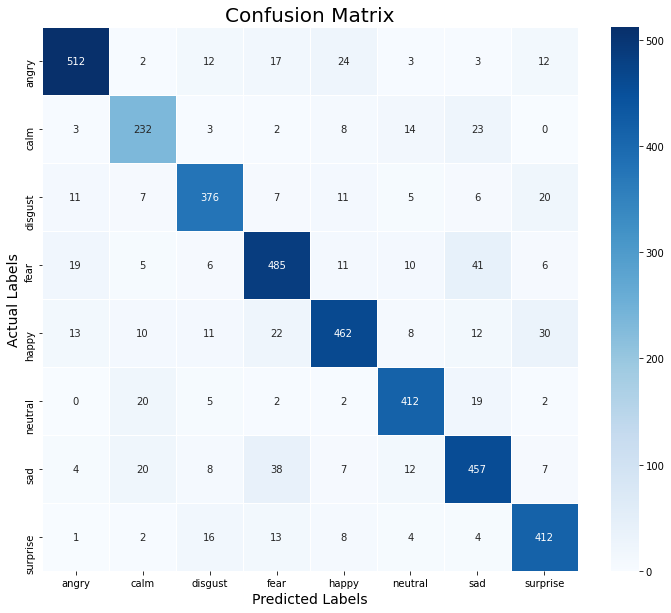

In [15]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [16]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.91      0.88      0.89       585
        calm       0.78      0.81      0.80       285
     disgust       0.86      0.85      0.85       443
        fear       0.83      0.83      0.83       583
       happy       0.87      0.81      0.84       568
     neutral       0.88      0.89      0.89       462
         sad       0.81      0.83      0.82       553
    surprise       0.84      0.90      0.87       460

    accuracy                           0.85      3939
   macro avg       0.85      0.85      0.85      3939
weighted avg       0.85      0.85      0.85      3939



In [17]:
from pydub import AudioSegment
import wave
import os
import numpy as np
import librosa
import math
import contextlib

## if wanted to test the other audio just take the audio in . wav format and keep the file in folder Speech Emotion Recognition
## just give the name  of audio file in wav  in fname just below . replace the name House_of_Commons_06-09-17_12-38-24 with your audio file
## audio file must be in .wav and saved in same folder where ipynb are

In [18]:
# splitting the file in 3 sec segments for accurate pred.
# loading the input audio file for spliting it into 3 sec  segments and saving it into the folder newAudio 
# it only accepts .wav files so if you have .mp3 convert it into .wav and add it into the same folder where is ipynb file
fname = 'House_of_Commons_06-09-17_12-38-24.wav'
with contextlib.closing(wave.open(fname,'r')) as f:
    frames = f.getnframes()
    rate = f.getframerate()
    duration = frames / float(rate)
Audio = AudioSegment.from_wav(fname)
# Segmenting the audio file to small files of length 2 sec
duration = math.floor(duration)
dur=(duration//3)
for i in range(dur):
  newAudio = Audio[i*3000:(i+1)*3000]
  newAudio.export('./newAudio/'+str(i)+'.wav', format="wav")

In [19]:
newAudio='.\\newAudio\\'

In [20]:
# making dataframe of audio files with there path location . 
newAudio_directory_list = os.listdir(newAudio)
file_path = []

for file in newAudio_directory_list:
    file_path.append(newAudio + file)

# dataframe for path of files.
data_path = pd.DataFrame(file_path, columns=['Path'])

In [21]:
data_path

,Path
0,.\newAudio\0.wav
1,.\newAudio\1.wav
2,.\newAudio\2.wav
3,.\newAudio\3.wav
4,.\newAudio\4.wav
5,.\newAudio\5.wav


In [22]:
x = []
for path, in zip(data_path.Path,):
    data, sample_rate = librosa.load(path)
    x.append(extract_features(data))
    
x

[array([ 1.26303335e-01,  4.94401306e-01,  5.45911610e-01,  6.17909372e-01,
         7.16507196e-01,  7.74396718e-01,  7.64475405e-01,  7.28482425e-01,
         6.74105465e-01,  5.87095201e-01,  5.76667249e-01,  5.78643262e-01,
         5.14126420e-01, -1.56617615e+02,  1.09907890e+02, -3.45099678e+01,
         2.57374072e+00, -1.65272903e+01, -1.27717514e+01, -1.45947485e+01,
        -1.27822189e+01, -1.68151398e+01,  3.97133613e+00, -1.33047473e+00,
         9.08711731e-01, -1.07458706e+01, -6.72570992e+00, -6.30577660e+00,
        -7.33068645e-01, -9.23083496e+00,  1.28996563e+00, -4.30015898e+00,
         4.01594019e+00,  6.81511983e-02,  2.31866650e-02,  3.87876555e-02,
         3.96281183e-02,  1.18627526e-01,  1.81397244e-01,  4.26912338e-01,
         5.25149047e-01,  6.36371434e-01,  6.96833372e-01,  9.72208142e-01,
         1.30903232e+00,  2.48383403e+00,  2.72733092e+00,  3.27830195e+00,
         7.26679659e+00,  4.00636101e+00,  3.47475743e+00,  4.21553516e+00,
         2.7

In [23]:
len(x)


6

In [24]:
# converting the features  array to data frame and saving it as csv file
Feature = pd.DataFrame(x)
Feature

,0,1,2,3,4,5,6,7,8,9,...,152,153,154,155,156,157,158,159,160,161
0,0.126303,0.494401,0.545912,0.617909,0.716507,0.774397,0.764475,0.728482,0.674105,0.587095,...,0.023270,0.020933,0.020894,0.012229,0.016899,0.025703,0.014064,0.015592,0.009559,0.000602
1,0.098513,0.449037,0.493890,0.619178,0.712863,0.611046,0.577115,0.535538,0.520863,0.586374,...,0.004271,0.004372,0.003276,0.002099,0.003073,0.002828,0.002364,0.001896,0.000600,0.000041
2,0.075368,0.529413,0.482945,0.494195,0.485284,0.424143,0.478742,0.572545,0.598314,0.576155,...,0.001095,0.000954,0.000862,0.000730,0.000717,0.000571,0.000451,0.000349,0.000120,0.000009
3,0.070598,0.507972,0.515324,0.613884,0.609293,0.550304,0.568671,0.549349,0.556482,0.594855,...,0.001093,0.000771,0.000546,0.000432,0.000430,0.000759,0.000711,0.000498,0.000194,0.000013
4,0.102584,0.601681,0.590768,0.629348,0.634482,0.588618,0.630221,0.617111,0.578572,0.600252,...,0.003337,0.002807,0.001970,0.001232,0.001001,0.001195,0.001003,0.000866,0.000308,0.000025
5,0.106517,0.516985,0.480055,0.537558,0.575338,0.500227,0.554695,0.614691,0.559817,0.459257,...,0.002737,0.003220,0.001233,0.001789,0.002038,0.003964,0.003325,0.002281,0.000814,0.000051


In [25]:
x_ = Feature.values
x_

array([[ 1.26303335e-01,  4.94401306e-01,  5.45911610e-01,
         6.17909372e-01,  7.16507196e-01,  7.74396718e-01,
         7.64475405e-01,  7.28482425e-01,  6.74105465e-01,
         5.87095201e-01,  5.76667249e-01,  5.78643262e-01,
         5.14126420e-01, -1.56617615e+02,  1.09907890e+02,
        -3.45099678e+01,  2.57374072e+00, -1.65272903e+01,
        -1.27717514e+01, -1.45947485e+01, -1.27822189e+01,
        -1.68151398e+01,  3.97133613e+00, -1.33047473e+00,
         9.08711731e-01, -1.07458706e+01, -6.72570992e+00,
        -6.30577660e+00, -7.33068645e-01, -9.23083496e+00,
         1.28996563e+00, -4.30015898e+00,  4.01594019e+00,
         6.81511983e-02,  2.31866650e-02,  3.87876555e-02,
         3.96281183e-02,  1.18627526e-01,  1.81397244e-01,
         4.26912338e-01,  5.25149047e-01,  6.36371434e-01,
         6.96833372e-01,  9.72208142e-01,  1.30903232e+00,
         2.48383403e+00,  2.72733092e+00,  3.27830195e+00,
         7.26679659e+00,  4.00636101e+00,  3.47475743e+0

In [26]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_ = scaler.fit_transform(x_)

In [27]:
# Add a new dimention to the features array to be used by the cnn model
x_ = np.expand_dims(x_, axis=2)
y = new_model.predict(x_)



In [28]:
y_pred = encoder.inverse_transform(y)
y_pred

array([['happy'],
       ['happy'],
       ['happy'],
       ['happy'],
       ['fear'],
       ['neutral']], dtype=object)

In [29]:
pre_newAudio= y.tolist()
pre_newAudio


[[0.007859697565436363,
  0.0011741450289264321,
  3.6980814911657944e-05,
  0.03915981203317642,
  0.9497184157371521,
  0.00024284678511321545,
  0.0018012099899351597,
  6.898210358485812e-06],
 [0.0001237385004060343,
  0.0477270632982254,
  4.650791254334763e-07,
  0.001154097612015903,
  0.950717031955719,
  2.533547012717463e-05,
  0.00025186530547216535,
  3.6162481364954147e-07],
 [0.0872998833656311,
  0.03275977447628975,
  0.08258239179849625,
  0.0732702985405922,
  0.5812145471572876,
  0.021600741893053055,
  0.04470943287014961,
  0.07656291872262955],
 [0.0008729835390113294,
  0.0024764365516602993,
  1.3000661738260533e-06,
  0.0011638619471341372,
  0.995307981967926,
  7.927158549136948e-06,
  0.00016755543765611947,
  1.931715587488725e-06],
 [0.17187416553497314,
  1.4681945659233975e-09,
  1.2573809726745822e-05,
  0.7963447570800781,
  0.01320068072527647,
  8.912943485483993e-06,
  0.018532147631049156,
  2.670788308023475e-05],
 [2.3493740286539833e-09,
  3.2

In [30]:
#making dataframe of predicted list for visualization
pred_input_audio=pd.DataFrame(pre_newAudio)
pred_input_audio

,0,1,2,3,4,5,6,7
0,7.859698e-03,1.174145e-03,3.698081e-05,0.039160,9.497184e-01,0.000243,0.001801,6.898210e-06
1,1.237385e-04,4.772706e-02,4.650791e-07,0.001154,9.507170e-01,0.000025,0.000252,3.616248e-07
2,8.729988e-02,3.275977e-02,8.258239e-02,0.073270,5.812145e-01,0.021601,0.044709,7.656292e-02
3,8.729835e-04,2.476437e-03,1.300066e-06,0.001164,9.953080e-01,0.000008,0.000168,1.931716e-06
4,1.718742e-01,1.468195e-09,1.257381e-05,0.796345,1.320068e-02,0.000009,0.018532,2.670788e-05
5,2.349374e-09,3.256420e-06,5.837158e-09,0.000046,4.189215e-07,0.999494,0.000457,5.976856e-10


In [31]:
#rounding off the values
pred_input_audio_new=pred_input_audio.round(4)

In [32]:
pred_input_audio_new.columns=['angry', 'calm', 'disgust', 'fear', 'happy', 'neutral', 'sad','surprise']

In [33]:
red_input_audio_new=pred_input_audio_new.multiply(100)
red_input_audio_new

,angry,calm,disgust,fear,happy,neutral,sad,surprise
0,0.79,0.12,0.00,3.92,94.97,0.02,0.18,0.00
1,0.01,4.77,0.00,0.12,95.07,0.00,0.03,0.00
2,8.73,3.28,8.26,7.33,58.12,2.16,4.47,7.66
3,0.09,0.25,0.00,0.12,99.53,0.00,0.02,0.00
4,17.19,0.00,0.00,79.63,1.32,0.00,1.85,0.00
5,0.00,0.00,0.00,0.00,0.00,99.95,0.05,0.00


In [34]:
len(red_input_audio_new.index)

6

In [35]:
red_input_audio_new.to_csv("Resut.csv",index=False)

In [36]:
import os, re, os.path
mypath = "newAudio"
for root, dirs, files in os.walk(mypath):
    for file in files:
        os.remove(os.path.join(root, file))

## OPEN Result.csv to see the pred results of audio file segmented in 3 sec 